
### Introduction

In [ ]:
# general imports
import pandas as pd
import numpy as np
import math

# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# SKlearn distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

# SKlearn scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# Sklearn model creation
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# SKlearn vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# SKlearn accuracy evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# SKlearn evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# SKlearn gridsearch
from sklearn.model_selection import GridSearchCV

# SKlearn combinations & polynomials
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

#SKlearn one hot encoder
from sklearn.preprocessing import OneHotEncoder

# SKlearn regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# SKlearn errors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# time series split, for time-based data
from sklearn.model_selection import TimeSeriesSplit

# SKlearn Clustering
from sklearn.cluster import KMeans
from contextlib import redirect_stderr

# Additional
import random
import warnings

In [ ]:
def access_excel_from_github(url, sheet_name):
    # Read the Excel file from the URL directly
    df = pd.read_excel(url, sheet_name=sheet_name, engine='openpyxl')
    return df

# Question 4

**Analytical Questions**: Given a set of features for a company, predict its market cap, based on the financial data of the top 100 companies.

**Comments**: This question seeks to understand the factors determining the market cap of a company. It is useful in tackling how new companies may fit into the top 100 US & Candian companies by market cap. These insights can be drawn from looking at the different features which determine the market cap for the top 100 companies.


**Data Used**: We will be using the same data as Question 1. This is the list of top 100 publicly listed companies by market cap in US and Canada. The features and observations will be the same as above, looking at the different latest financial ratios of the top 100 companies. In this case, the company that we are making predictions on is Lululemon Athletica.


**Proposed Solution**:
Model 1: A multivariate linear regression model
Model 2: The K Nearest Neighbors Regression for values of K which will be optimized using grid search

Proposed Evaluation:
We will evaluate the models using cross validation and optimize for the lowest root mean squared error. We will then predict the market cap of Lululemon and compare that figure with the actual market cap.


Relevant Data
https://github.com/Nayrbnat/DS-112/raw/main/Qn4/Qualities%20of%20Good%20Companies.xlsx


### Explanation of key terms in the data

### Pre-processing of data

**Missing Values**

Rationale for filling future values with NA:

In [ ]:
df = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn1/Qualities%20of%20Good%20Companies.xlsx', 'Data')
df.columns = df.iloc[3,]
df = df.iloc[6:,:].reset_index(drop=True)

# Adjusting for duplicates
duplicates = df.columns.duplicated()

if duplicates.any():
    new_columns = pd.Series(df.columns).astype(str) + pd.Series(range(len(df.columns))).astype(str)
    df.columns = pd.Series(df.columns).where(~duplicates, new_columns)
# Filling NA values with future values
df = df.ffill().bfill() #Fill missing values with forward values, in the event there exist no forward value, fill with backvalue

# Check for NA values
df.isna().sum()

,0
3,
SP_ENTITY_NAME,0
SP_ENTITY_ID,0
SP_GEOGRAPHY,0
SP_COMPANY_TYPE,0
SP_MARKETCAP_PERIOD_END,0
SP_TOTAL_REV,0
SP_EBITDA,0
SP_EBIT,0
SP_NET_INC,0


In [ ]:
# Renaming the columns
df = df.rename(columns = {
    'SP_ENTITY_NAME': 'Company',
    'SP_ENTITY_ID': 'S&P ID',
    'SP_GEOGRAPHY': 'Geography',
    'SP_COMPANY_TYPE': 'Company Type',
    'SP_MARKETCAP_PERIOD_END': 'Market Cap',
    'SP_TOTAL_REV': 'Total Revenue',
    'SP_EBITDA': 'EBITDA_LFY',
    'SP_EBIT': 'EBIT_LFY',
    'SP_NET_INC': 'Net Income_LFY',
    'SP_TEV_EBITDA': 'TEV/EBITDA',
    'SP_PE': 'SP_P/E after extra',
    'SP_PBV_X': 'SP_P/B',
    'SP_DEBT_TO_EQUITY': 'Total Debt/Total Equity',
    'SP_ROA': 'ROAA',
    'SP_ROE': 'ROAE',
    'SP_BVPS': 'Basic Book Value per shares',
    'SP_DIV_YIELD': 'Dividend Yield',
    'SP_VOLUME_AVG_DAILY': 'Volume',
    'SP_SHORT_INT': 'Short Interest Jun 24',
    'SP_SHORT_INT_RATIO': 'Short Interest Ratio_1D',
    'SP_BETA1YR': 'Beta_1Y',
    'SP_BETA_3YR': 'Beta_3Y',
    'SP_EPS_MEDIAN_EST': 'FY26_Median_EPS_EST',
    'SP_EPS_REPORTED_EST': 'FY26_Median_EPS_EST_GAAP',
    'SP_CASH_EPS_MEDIAN_EST': 'FY26_Median_Cash_EPS_EST',
    'SP_DPS_MEDIAN_EST': 'FY26_Median_DPS_EST',
    'SP_FCF_MEDIAN_EST': 'FY26_Median_FCF_EST',
    'IQ_TEV_EBIT_OUT': 'Diluted_TEV/EBIT',
    'IQ_TEV_EBITDA_OUT': 'Diluted_TEV/EBITDA',
    'IQ_PBV_X': 'IQ_P/B',
    'IQ_PE': 'IQ_P/E',
    'SP_TEV_EBIT_FWD_OUT': 'FY26_Forward_TEV/EBIT',
    '354780': 'Total Earnings Transcript Net Positivity Score',
    'SP_PCT_HELD_BY_INST_OWNER': 'Percent Institution Ownership (Owner 1)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER': 'Percentage change in insider holder (Owner 1)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER35': 'Percentage change in insider holder (Owner 2)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER36': 'Percentage change in insider holder (Owner 3)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER37': 'Percentage change in insider holder (Owner 4)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER38': 'Percentage change in insider holder (Owner 5)',
    'SP_PCT_HELD_BY_INSIDER_OWNER': 'Percent Insider Ownership (Owner 1)',
    'SP_PCT_HELD_BY_INSIDER_OWNER40': 'Percent Insider Ownership (Owner 2)',
    'SP_PCT_HELD_BY_INSIDER_OWNER41': 'Percent Insider Ownership (Owner 3)',
    'SP_PCT_HELD_BY_INSIDER_OWNER42': 'Percent Insider Ownership (Owner 4)',
    'SP_PCT_HELD_BY_INSIDER_OWNER43': 'Percent Insider Ownership (Owner 5)',
    'IQ_INDUSTRY': 'Industry',
    'IQ_SECTOR': 'Sector',
    'RD_CREDIT_RATING_GLOBAL': 'S&P Credit Rating',
    'PCT_OWNED_INSIDERS': 'Total Percent Insider Ownership',
    'SP_NO_INSTITUTIONAL_INVESTORS': 'Number of Institutional Investors'})
df_numeric = df.drop(columns = ['Company','Company Type','Sector','Industry','S&P Credit Rating','Geography','FY26_Median_EPS_EST_GAAP']).apply(pd.to_numeric, errors='coerce').dropna()
df.head()

3,Company,S&P ID,Geography,Company Type,Market Cap,Total Revenue,EBITDA_LFY,EBIT_LFY,Net Income_LFY,TEV/EBITDA,...,Percent Insider Ownership (Owner 1),Percent Insider Ownership (Owner 2),Percent Insider Ownership (Owner 3),Percent Insider Ownership (Owner 4),Percent Insider Ownership (Owner 5),Industry,Sector,S&P Credit Rating,Total Percent Insider Ownership,Number of Institutional Investors
0,Aflac Incorporated (NYSE:AFL),103316,United States and Canada,Public Company,4.772452e+04,18701000.0,3252679.0,5457000.0,4659000.0,10.532477,...,0.55,0.06,0.04,0.03,0.02,Insurance,Financials,A-,0.83,1632
1,Agnico Eagle Mines Limited (NYSE:AEM),4347844,United States and Canada,Public Company,5.455375e+04,6626909.0,3252679.0,1428841.0,1941307.0,10.532477,...,0.03,0.03,0.02,0.01,0.01,Metals and Mining,Materials,NR,0.12,913
2,Alphabet Inc. (NASDAQGS:GOOGL),4633618,United States and Canada,Public Company,1.740537e+06,307394000.0,100172000.0,88226000.0,73795000.0,17.050398,...,5.91,3.16,0.90,0.32,0.04,Interactive Media and Services,Communication Services,AA+,10.38,5330
3,"Amazon.com, Inc. (NASDAQGS:AMZN)",3001792,United States and Canada,Public Company,1.577593e+06,574785000.0,85515000.0,36852000.0,30425000.0,16.679114,...,8.92,1.77,0.02,0.00,0.00,Broadline Retail,Consumer Discretionary,AA,10.72,5753
4,"American Electric Power Company, Inc. (NASDAQG...",4006321,United States and Canada,Public Company,4.273671e+04,18982300.0,6979700.0,3955600.0,2212600.0,12.930122,...,0.01,0.01,0.01,0.00,0.00,Electric Utilities,Utilities,BBB+,0.06,1502


In [ ]:
# Removing outliers
outlier_count = pd.Series(0, index=df_numeric.index)  # Initialize a series to count outliers for each row

for col in df_numeric.columns:
    Q1 = df_numeric[col].quantile(0.25)  # 25th percentile
    Q3 = df_numeric[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                        # Interquartile Range

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR

    # Identify outliers
    col_outliers = df_numeric[(df_numeric[col] < lower_bound) | (df_numeric[col] > upper_bound)]

    # Increment the count of outliers for these rows
    outlier_count[col_outliers.index] += 1

# Flag rows as outliers if they have outliers in more than 5 columns
outliers = outlier_count[outlier_count > 5].index.tolist()

# Finding the companies that appear as outliers
df_outliers = df.iloc[outliers]

df_outliers

3,Company,S&P ID,Geography,Company Type,Market Cap,Total Revenue,EBITDA_LFY,EBIT_LFY,Net Income_LFY,TEV/EBITDA,...,Percent Insider Ownership (Owner 1),Percent Insider Ownership (Owner 2),Percent Insider Ownership (Owner 3),Percent Insider Ownership (Owner 4),Percent Insider Ownership (Owner 5),Industry,Sector,S&P Credit Rating,Total Percent Insider Ownership,Number of Institutional Investors
2,Alphabet Inc. (NASDAQGS:GOOGL),4633618,United States and Canada,Public Company,1.740537e+06,307394000.0,100172000.0,88226000.0,73795000.0,17.050398,...,5.91,3.16,0.90,0.32,0.04,Interactive Media and Services,Communication Services,AA+,10.38,5330
8,"Apollo Global Management, Inc. (NYSE:APO)",4204256,United States and Canada,Public Company,5.290983e+04,31944000.0,6006000.0,2919500.0,6509000.0,13.721773,...,7.31,6.03,4.89,1.01,0.63,Financial Services,Financials,A,21.10,1067
22,Brookfield Corporation (TSX:BN),4066647,United States and Canada,Public Company,6.131298e+04,97992000.0,25589000.0,16514000.0,5105000.0,16.326749,...,3.59,2.63,1.42,1.10,0.82,Capital Markets,Financials,A-,10.99,890
49,KKR & Co. Inc. (NYSE:KKR),4165107,United States and Canada,Public Company,7.332271e+04,18663644.0,3784000.0,142933000.0,5357086.0,39.691641,...,9.94,9.34,2.37,2.07,0.35,Capital Markets,Financials,A,24.27,1180


There are clearly outliers in this case, let me implement a function that removes outliers

In [ ]:
# Remove outliers
df = df.drop(outliers)
df.shape[0]

96

# Part 1 - Exploratory Data Analysis (EDA)

---



### EDA: Understanding Features

In [ ]:
# Identifying the number of unique values for each feature to classify as numeric or categorical
def unique_values_df(df):
    unique_counts = df.nunique()
    return pd.DataFrame(unique_counts, columns=['Unique_Values'])

In [ ]:
# How many unique values does each predictor have?
unique_values_df(df).sort_values(by='Unique_Values', ascending=True).head(10)

,Unique_Values
3,
Geography,1
Company Type,1
Percent Insider Ownership (Owner 5),8
Sector,10
Percent Insider Ownership (Owner 4),11
S&P Credit Rating,12
Percent Insider Ownership (Owner 3),13
Industry,24
Percent Insider Ownership (Owner 2),26


We can infer from here that Geograph and Company Type should not be considered in the model since it is identical for all firms.

In [ ]:
df.columns

Index(['Company', 'S&P ID', 'Geography', 'Company Type', 'Market Cap',
       'Total Revenue', 'EBITDA_LFY', 'EBIT_LFY', 'Net Income_LFY',
       'TEV/EBITDA', 'SP_P/E after extra', 'SP_P/B', 'Total Debt/Total Equity',
       'ROAA', 'ROAE', 'Basic Book Value per shares', 'Dividend Yield',
       'Volume', 'Short Interest Jun 24', 'Short Interest Ratio_1D', 'Beta_1Y',
       'Beta_3Y', 'FY26_Median_EPS_EST', 'FY26_Median_EPS_EST_GAAP',
       'FY26_Median_Cash_EPS_EST', 'FY26_Median_DPS_EST',
       'FY26_Median_FCF_EST', 'Diluted_TEV/EBIT', 'Diluted_TEV/EBITDA',
       'IQ_P/B', 'IQ_P/E', 'FY26_Forward_TEV/EBIT',
       'Total Earnings Transcript Net Positivity Score',
       'Percent Institution Ownership (Owner 1)',
       'Percentage change in insider holder (Owner 1)',
       'Percentage change in insider holder (Owner 2)',
       'Percentage change in insider holder (Owner 3)',
       'Percentage change in insider holder (Owner 4)',
       'Percentage change in insider holder (Ow

**List of numerical variables**: All other variables

**List of categorical variables**: Geography, Company Type, S&P Credit Rating, Sector, Industry

In [ ]:
categorical_columns =['Company','Company Type','Sector','Industry','S&P Credit Rating','Geography']
numeric_columns = list(set(df.columns) - set(categorical_columns))

### EDA: Checking for Multi-Collinearity between features

In [ ]:
# finding the largest positive correlation between features
df_numeric = df.drop(columns = categorical_columns).apply(pd.to_numeric, errors='coerce').dropna()
df_corr = df_numeric.corr()

# create and apply a mask to eliminate the correlation of one variable with itself
mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)
masked_corr = df_corr.where(mask)

df_corr

3,S&P ID,Market Cap,Total Revenue,EBITDA_LFY,EBIT_LFY,Net Income_LFY,TEV/EBITDA,SP_P/E after extra,SP_P/B,Total Debt/Total Equity,...,Percentage change in insider holder (Owner 3),Percentage change in insider holder (Owner 4),Percentage change in insider holder (Owner 5),Percent Insider Ownership (Owner 1),Percent Insider Ownership (Owner 2),Percent Insider Ownership (Owner 3),Percent Insider Ownership (Owner 4),Percent Insider Ownership (Owner 5),Total Percent Insider Ownership,Number of Institutional Investors
3,,,,,,,,,,,,,,,,,,,,,
S&P ID,1.000000,0.080954,-0.024479,-0.079820,-0.167764,-0.036357,0.082055,0.119373,0.150462,-0.080736,...,0.005033,-0.020699,0.096946,0.063806,0.153873,0.088511,0.141738,0.081402,0.078324,0.132144
Market Cap,0.080954,1.000000,0.665597,0.729684,0.598572,0.842092,0.062244,0.062049,0.391754,-0.099849,...,-0.038809,-0.127929,-0.130093,0.149084,0.075097,-0.130435,-0.197275,-0.213754,0.137960,0.752811
Total Revenue,-0.024479,0.665597,1.000000,0.658458,0.553797,0.714788,-0.113849,-0.062071,0.124789,-0.102564,...,-0.043697,-0.068500,-0.084725,0.270703,0.178264,-0.113490,-0.169991,-0.173134,0.261586,0.619010
EBITDA_LFY,-0.079820,0.729684,0.658458,1.000000,0.697538,0.800775,-0.218048,-0.183062,0.139000,0.087020,...,0.020284,-0.024467,-0.131707,0.224310,0.005696,-0.143218,-0.188831,-0.126436,0.197968,0.468423
EBIT_LFY,-0.167764,0.598572,0.553797,0.697538,1.000000,0.821203,-0.066720,-0.244500,0.076919,0.131373,...,0.001906,0.023937,-0.082362,0.125045,-0.071056,-0.151945,-0.191217,-0.129370,0.099911,0.515242
Net Income_LFY,-0.036357,0.842092,0.714788,0.800775,0.821203,1.000000,-0.016923,-0.117680,0.277581,-0.055388,...,-0.053650,-0.070700,-0.071966,0.268943,-0.009088,-0.107098,-0.172970,-0.147626,0.237406,0.623736
TEV/EBITDA,0.082055,0.062244,-0.113849,-0.218048,-0.066720,-0.016923,1.000000,0.385608,0.313131,-0.160906,...,-0.037829,-0.002072,0.097216,0.246425,0.443329,0.334558,0.292218,0.183199,0.282182,0.079497
SP_P/E after extra,0.119373,0.062049,-0.062071,-0.183062,-0.244500,-0.117680,0.385608,1.000000,0.201222,-0.214029,...,0.028261,0.026634,0.074139,0.035538,0.151620,0.002397,-0.010496,-0.057619,0.048637,0.118788
SP_P/B,0.150462,0.391754,0.124789,0.139000,0.076919,0.277581,0.313131,0.201222,1.000000,0.146201,...,-0.089680,-0.037876,-0.033733,0.007932,-0.007874,0.002772,-0.061237,-0.116240,0.003933,0.404097


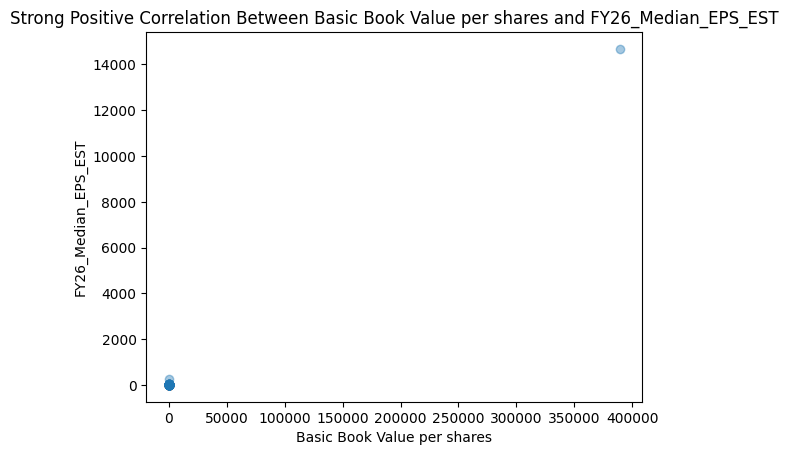

The correlation value between the two features are 0.9999799225161111.


In [ ]:
# Find and plot the visualisation of the index of the most positive correlation value
max_corr_value = masked_corr.max().max()
max_corr_idx = masked_corr.stack()[masked_corr.stack() == max_corr_value].index

# identify the features
feature1 = max_corr_idx[0][0]
feature2 = max_corr_idx[0][1]

fig = plt.scatter(x=df[feature1], y=df[feature2], alpha=0.4)

# label the diagram
plt.title(f'Strong Positive Correlation Between {feature1} and {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.show()
print(f"The correlation value between the two features are {max_corr_value}.")

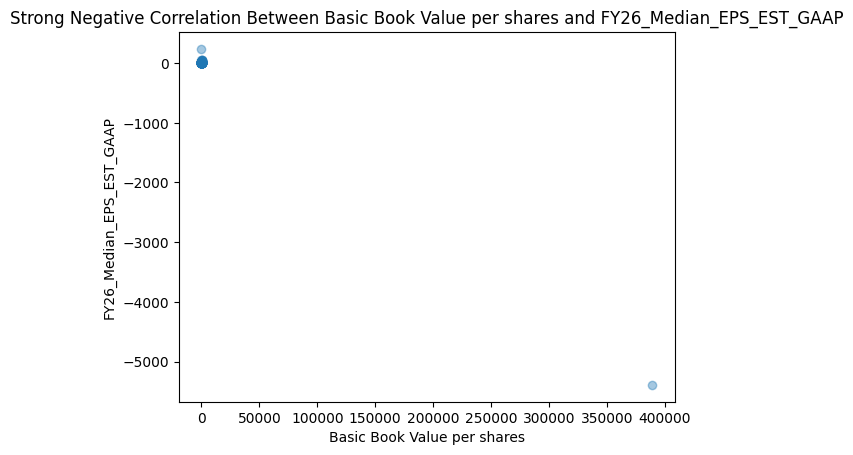

The correlation value between the two features are -0.9998152713150891.


In [ ]:
# Find and plot the visualisation of the index of the most negative correlation value
min_corr_value = masked_corr.min().min()
min_corr_idx = masked_corr.stack()[masked_corr.stack() == min_corr_value].index

# identify the features
feature1 = min_corr_idx[0][0]
feature2 = min_corr_idx[0][1]

fig = plt.scatter(x=df[feature1], y=df[feature2], alpha=0.4)

# label the diagram
plt.title(f'Strong Negative Correlation Between {feature1} and {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.show()
print(f"The correlation value between the two features are {min_corr_value}.")

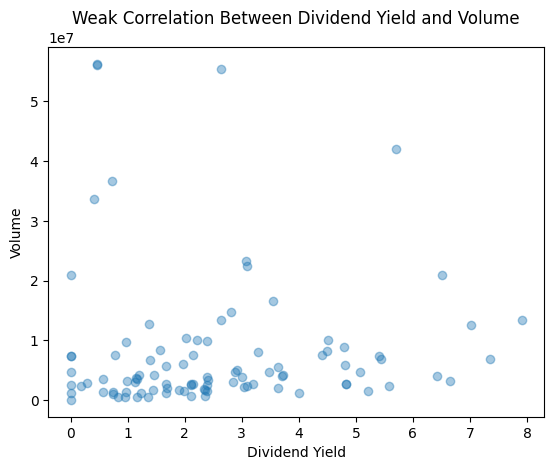

The correlation value between the two features are 0.9999799225161111.


In [ ]:
# Find and plot the visualisation of the index of weakest correlation value
neutral_corr_value = masked_corr.abs().min().min()
neutral_corr_idx = masked_corr.stack()[masked_corr.stack() == neutral_corr_value].index

# identify the features
feature1 = neutral_corr_idx[0][0]
feature2 = neutral_corr_idx[0][1]

fig = plt.scatter(x=df[feature1], y=df[feature2], alpha=0.4)

# label the diagram
plt.title(f'Weak Correlation Between {feature1} and {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.show()
print(f"The correlation value between the two features are {max_corr_value}.")

The level of correlation between the different features tell us which features to select in the linear regression model. This is because the linear model assumes independence of features and does not perform well if features are correlated.

From the above plots, we can conclude that dividend yield & volume

## EDA: Feature Relationship with Market Cap

In [ ]:
# only considering numeric variables now

In [ ]:
df_corr_cap = df_numeric.iloc[:, 2:].apply(lambda x: df_numeric['Market Cap'].corr(x)).sort_values(ascending = False)
df_corr_cap

,0
3,
FY26_Median_FCF_EST,0.869797
Net Income_LFY,0.842092
Number of Institutional Investors,0.752811
EBITDA_LFY,0.729684
Total Revenue,0.665597
Volume,0.637001
EBIT_LFY,0.598572
Short Interest Jun 24,0.542563
ROAA,0.449767


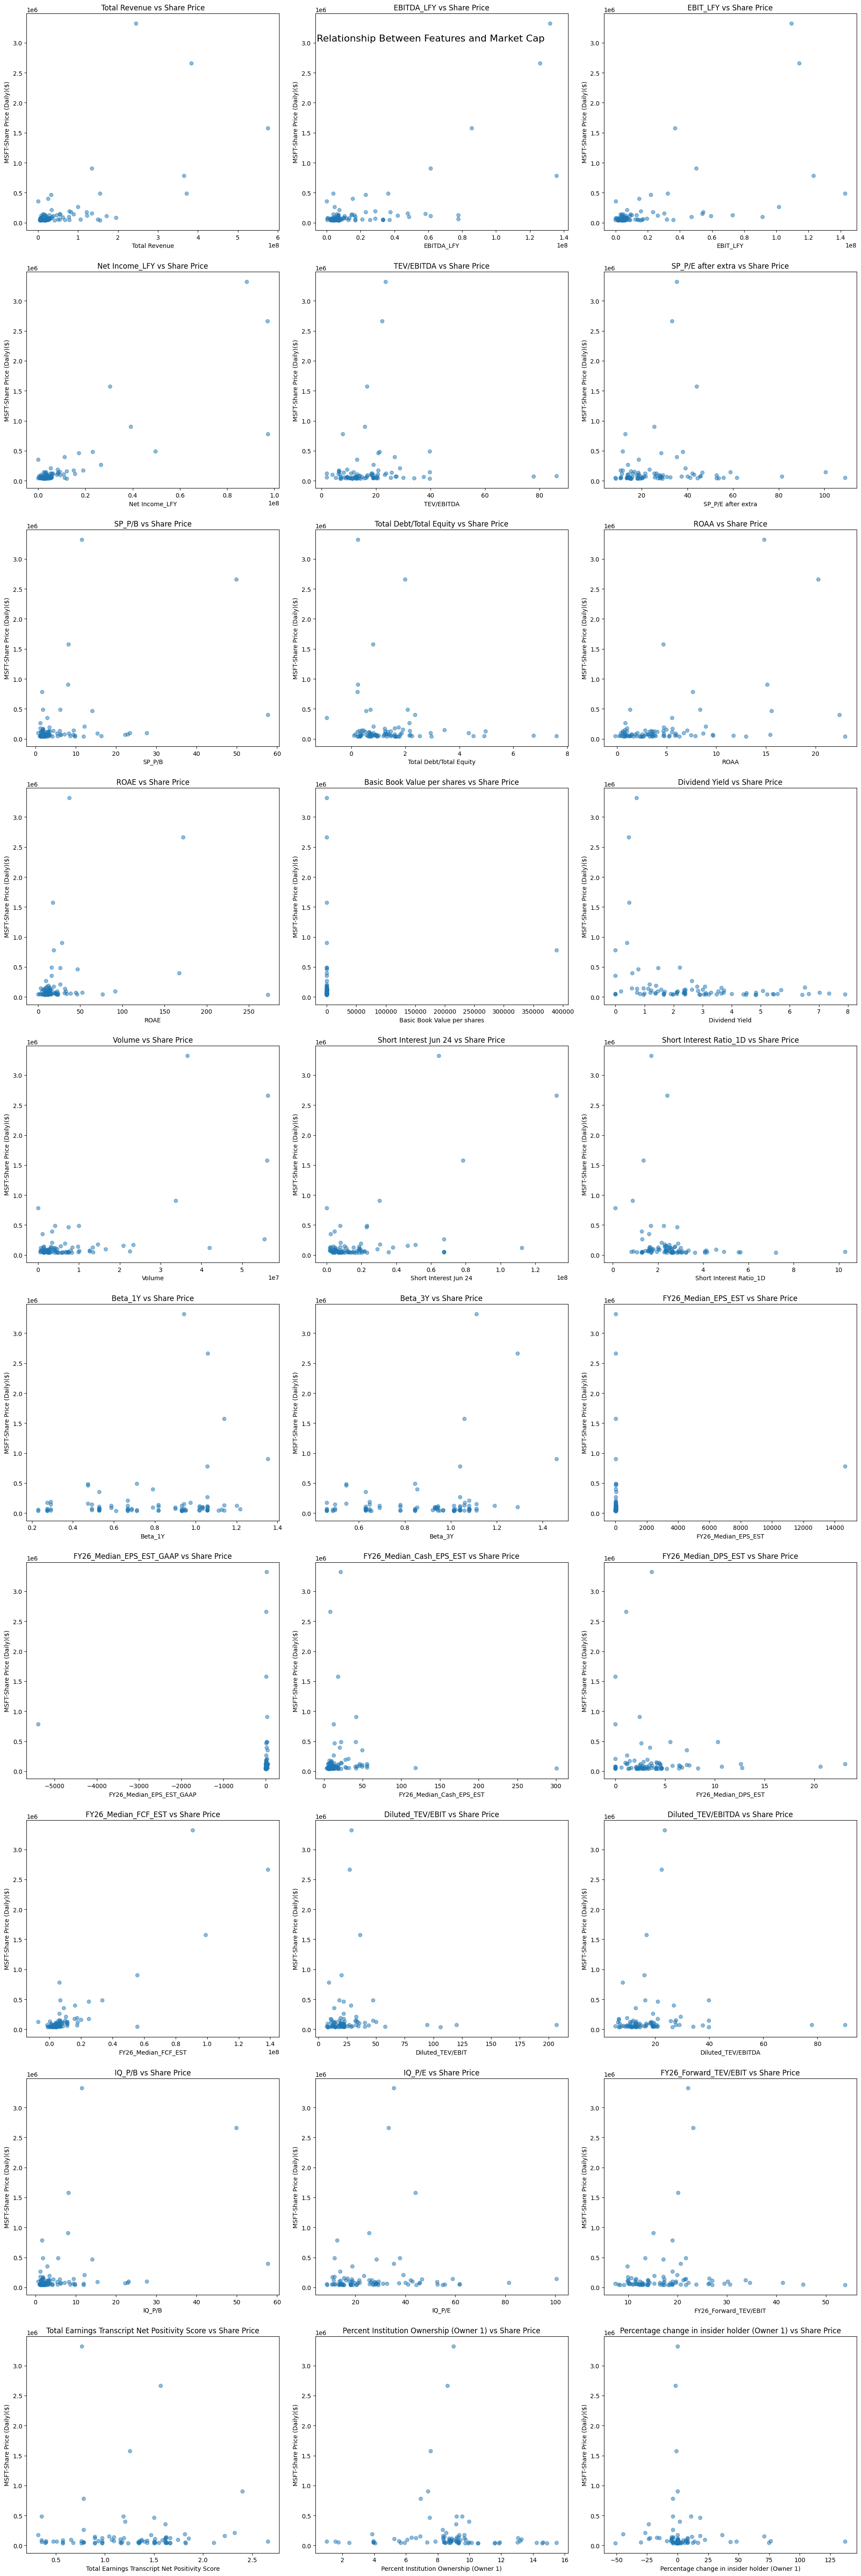

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(10, 3, figsize=(20, 60))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get the feature names from the DataFrame
features = df_numeric.iloc[:, 2:].columns

# Create a colormap for the colorbar
cmap = plt.get_cmap('viridis')

# Iterate over each feature and subplot axis to plot scatter plots
for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        x=df_numeric[feature],
        y=df_numeric['Market Cap'],
        alpha=0.5
    )
    ax.set_title(f"{feature} vs Share Price")
    ax.set_xlabel(feature)
    ax.set_ylabel('MSFT-Share Price (Daily)($)')

# Add a title for the entire figure
fig.suptitle('Relationship Between Features and Market Cap', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()



## EDA: Distribution of Categorical Variables

In [ ]:
for feature in categorical_columns:
  display(df[feature].value_counts())

,count
Company,
Aflac Incorporated (NYSE:AFL),1
Agnico Eagle Mines Limited (NYSE:AEM),1
"Simon Property Group, Inc. (NYSE:SPG)",1
Sempra (NYSE:SRE),1
S&P Global Inc. (NYSE:SPGI),1
...,...
"Dominion Energy, Inc. (NYSE:D)",1
"Digital Realty Trust, Inc. (NYSE:DLR)",1
Crown Castle Inc. (NYSE:CCI),1


,count
Company Type,
Public Company,96


,count
Sector,
Financials,42
Real Estate,9
Communication Services,9
Energy,8
Utilities,6
Information Technology,6
Health Care,5
Materials,4
Consumer Discretionary,4


,count
Industry,
Banks,14
Capital Markets,11
Insurance,8
"Oil, Gas and Consumable Fuels",8
Financial Services,7
Software,5
Specialized REITs,5
Health Care Providers and Services,5
Electric Utilities,4


,count
S&P Credit Rating,
A-,21
BBB+,19
BBB,18
A,10
AA-,8
A+,5
NR,4
BBB-,4
BB+,3


,count
Geography,
United States and Canada,96


# Part 2 Feature Selection

---

Based on the correlation of the features with the target variable, we created a list called **strong_features**. We then ran a rolling window cross validation and identified the top features for each model based on its negative root mean square error.

We also created interaction variables to better capture and model the relationship between features and the target variable - share price.

In [ ]:
# since the negative values of correlation with the market cap are relatively low, the strong correlations are positive

strong_features = list(df_corr_cap.head(5).index)


### Creating and evaluating interaction features

In [ ]:
df_combined = pd.concat([df_numeric, df[categorical_columns]], axis=1).fillna(0)

In [ ]:
# since 'company', 'company type' and 'geography' do not need to be considered, they can be excluded
filtered_categorical = ['Sector','Industry','S&P Credit Rating']

# from numeric features, remove 'market cap' and 'id' since they are not predictors here
filtered_numerical = list(set(numeric_columns)-set(['Market Cap', 'S&P ID']))

# make column transformer
ct = make_column_transformer(
    (StandardScaler(), filtered_numerical),
    (OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical),
    remainder="passthrough")

# make pipeline
pipeline = make_pipeline(ct,
LinearRegression())

# define X and y
X = df_combined[filtered_numerical + filtered_categorical]
y = df_combined['Market Cap']

In [ ]:
# defining polynomial features
poly = PolynomialFeatures(2, interaction_only = True)

# defining X, where interaction features can only be made with numerical features
I = df_combined[filtered_numerical]

# fit and transform to create interaction terms
interaction_terms = poly.fit_transform(I)

# place interaction variables into dataframe and merge with original data frame
interaction_df = pd.DataFrame(interaction_terms, columns=poly.get_feature_names_out(filtered_numerical))

# find list of features without S&P ID and Market Cap
to_remove = ['S&P ID','Market Cap']
interaction_variables = list(filter(lambda item: item not in to_remove, list(interaction_df.columns)))


# Part 3 Linear Regression Model
---

Workflow:

1. Create transformer, model and pipeline
2. Tune the model via cross-validation  to obtain best hyperparameters using all features
3. Test the model via cross-validation with updated optimal features
4. Test the model via cross-validation with interaction features added

In [ ]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Total Debt/Total Equity',
                                                   'Volume',
                                                   'Percent Insider Ownership '
                                                   '(Owner 1)',
                                                   'TEV/EBITDA',
                                                   'Percentage change in '
                                                   'insider holder (Owner 4)',
                                                   'FY26_Median_EPS_EST_GAAP',
                                                   'Percentage change in '
                                                   'insider holder (Owner 2)',
                                                   'Net Income_LFY',
                                                   'Percent...
                                                   'Percent Insider Ownership '
                                                   '(Owner 4)',
                                                   'ROAE', 'Dividend Yield',
                                                   'IQ_P/B',
                                                   'Percent Insider Ownership '
                                                   '(Owner 3)',
                                                   'FY26_Median_EPS_EST',
                                                   'EBITDA_LFY', 'ROAA',
                                                   'Short Interest Ratio_1D',
                                                   'Short Interest Jun 24',
                                                   'Beta_1Y', ...]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sector', 'Industry',
                                                   'S&P Credit Rating'])])),
                ('linearregression', LinearRegression())])

In [ ]:
# carry out grid search to determine best hyperparameters

grid_cv = GridSearchCV(
    pipeline,
    param_grid={
        "columntransformer__transformers": [
        [('scaler', StandardScaler(), filtered_numerical),
         ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical)],

        [('scaler', MinMaxScaler(), filtered_numerical),
         ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical)],

        [('scaler', Normalizer(), filtered_numerical),
         ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical)],
    ]
},

scoring="neg_root_mean_squared_error", cv=10)

grid_cv.fit(X, y)

rmse_lin_scaler = -grid_cv.best_score_

print(grid_cv.best_params_)
print(-grid_cv.best_score_)

{'columntransformer__transformers': [('scaler', Normalizer(), ['Total Debt/Total Equity', 'Volume', 'Percent Insider Ownership (Owner 1)', 'TEV/EBITDA', 'Percentage change in insider holder (Owner 4)', 'FY26_Median_EPS_EST_GAAP', 'Percentage change in insider holder (Owner 2)', 'Net Income_LFY', 'Percent Institution Ownership (Owner 1)', 'FY26_Median_FCF_EST', 'Diluted_TEV/EBITDA', 'SP_P/B', 'FY26_Forward_TEV/EBIT', 'FY26_Median_DPS_EST', 'Basic Book Value per shares', 'Percentage change in insider holder (Owner 5)', 'Beta_3Y', 'Percent Insider Ownership (Owner 2)', 'Percentage change in insider holder (Owner 3)', 'Percent Insider Ownership (Owner 4)', 'ROAE', 'Dividend Yield', 'IQ_P/B', 'Percent Insider Ownership (Owner 3)', 'FY26_Median_EPS_EST', 'EBITDA_LFY', 'ROAA', 'Short Interest Ratio_1D', 'Short Interest Jun 24', 'Beta_1Y', 'Number of Institutional Investors', 'FY26_Median_Cash_EPS_EST', 'Percent Insider Ownership (Owner 5)', 'Total Revenue', 'EBIT_LFY', 'Percentage change in i

In [ ]:
# since all of the feautures in the list are numerical, a new pipeline can be redefined
pipeline = make_pipeline(StandardScaler(),
LinearRegression())

from tqdm.notebook import tqdm
import time
import math

for i in tqdm(range(100)):
    time.sleep(0.1)

    lowest_error = float('inf')
    features = strong_features

    # this permutates over models which use only one input
    for feature in features:
      X = df_combined[[feature]]
      y = df_combined['Market Cap']
      rmse = -cross_val_score(pipeline, X, y, scoring = "neg_root_mean_squared_error", cv=10).mean()
      if rmse < lowest_error:
        lowest_error = rmse
        best_features = feature

    # this permutates over models of varying lengths, with a different mixture of features
    for size in range(2, len(features) + 1):
      for feature in combinations(features, size):
        feature_string = ",".join(feature)
        X = df_combined[list(feature)]
        y = df_combined['Market Cap']
        rmse = -cross_val_score(pipeline, X, y, scoring = "neg_root_mean_squared_error", cv=10).mean()
        if rmse < lowest_error:
          lowest_error = rmse
          best_features = feature

rmse_lin_feature = lowest_error
print(best_features)
print(lowest_error)

  0%|          | 0/100 [00:00<?, ?it/s]

('FY26_Median_FCF_EST', 'Net Income_LFY', 'Total Revenue')
158118.32476206223


In [ ]:
# Gridsearch for Best Features
X = df_combined[filtered_numerical + filtered_categorical]
# make column transformer
ct = make_column_transformer(
    (StandardScaler(), best_features),
    (OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical),
    remainder="drop")

# make pipeline
pipeline = make_pipeline(ct,
LinearRegression())

grid_cv_best_linear = GridSearchCV(
    pipeline,
    param_grid={
        "columntransformer__transformers": [
        [('scaler', StandardScaler(), best_features),
         ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical)],

        [('scaler', MinMaxScaler(), best_features),
         ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical)],

        [('scaler', Normalizer(), best_features),
         ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical)],
    ]
},

scoring="neg_root_mean_squared_error", cv=10)

grid_cv_best_linear.fit(X, y)

rmse_lin_scaler = -grid_cv_best_linear.best_score_

print(grid_cv_best_linear.best_params_)
print(grid_cv_best_linear.best_score_)


{'columntransformer__transformers': [('scaler', MinMaxScaler(), ('FY26_Median_FCF_EST', 'Net Income_LFY', 'Total Revenue')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Sector', 'Industry', 'S&P Credit Rating'])]}
-236274.5528724867


In [ ]:
# Gridsearch for Interaction Variables

# define X and y
I = interaction_df[interaction_variables]
y = df_combined['Market Cap']

# make pipeline & transformer
ct = make_column_transformer(
    (StandardScaler(), I.columns),
    remainder="drop")

pipeline = make_pipeline(ct,
LinearRegression())


grid_cv_interaction = GridSearchCV(
    pipeline,
    param_grid={
        "columntransformer__transformers": [
        [('scaler', StandardScaler(),I.columns)
         ],

        [('scaler', MinMaxScaler(), I.columns)],

        [('scaler', Normalizer(), I.columns)],
    ]
},

scoring="neg_root_mean_squared_error", cv=10)

grid_cv_interaction.fit(I, y)

rmse_lin_scaler = -grid_cv_interaction.best_score_

print(grid_cv_interaction.best_params_)
print(-grid_cv_interaction.best_score_)

{'columntransformer__transformers': [('scaler', Normalizer(), Index(['1', 'Total Debt/Total Equity', 'Volume',
       'Percent Insider Ownership (Owner 1)', 'TEV/EBITDA',
       'Percentage change in insider holder (Owner 4)',
       'FY26_Median_EPS_EST_GAAP',
       'Percentage change in insider holder (Owner 2)', 'Net Income_LFY',
       'Percent Institution Ownership (Owner 1)',
       ...
       'Total Earnings Transcript Net Positivity Score IQ_P/E',
       'Total Earnings Transcript Net Positivity Score Total Percent Insider Ownership',
       'Total Earnings Transcript Net Positivity Score Diluted_TEV/EBIT',
       'Total Earnings Transcript Net Positivity Score SP_P/E after extra',
       'IQ_P/E Total Percent Insider Ownership', 'IQ_P/E Diluted_TEV/EBIT',
       'IQ_P/E SP_P/E after extra',
       'Total Percent Insider Ownership Diluted_TEV/EBIT',
       'Total Percent Insider Ownership SP_P/E after extra',
       'Diluted_TEV/EBIT SP_P/E after extra'],
      dtype='object',

In [ ]:
# Combining results into a dataframe

result_linear = pd.DataFrame({
    'Model': ['Linear Regression with All Features', 'Linear Regression with Optimal Features', 'Linear Regression with Interaction Features'],
    'RMSE': [-grid_cv.best_score_, -grid_cv_best_linear.best_score_, -grid_cv_interaction.best_score_],
    'Best Features': [grid_cv.best_params_,grid_cv_best_linear.best_params_, grid_cv_interaction.best_params_]
})

result_linear

,Model,RMSE,Best Features
0,Linear Regression with All Features,7.547578e+06,{'columntransformer__transformers': [('scaler'...
1,Linear Regression with Optimal Features,2.362746e+05,{'columntransformer__transformers': [('scaler'...
2,Linear Regression with Interaction Features,1.838685e+07,{'columntransformer__transformers': [('scaler'...


## Evaluating the RMSE results of the 3 models

We tuned 3 different models above:

1. Linear Regression with all features
2. Linear Regression with Optimal Features
3. Linear Regeession with interaction terms.

The RMSE is the lowest for the Linear Regression with optimal features. This makes intuitive sense because the linear regression with optimal features would give a lower RMSE than the linear regression with all features.

For the third model, it recorded a higher RMSE due to having too many features. The model is likely overfitting the training data and the high variance results in a higher cross validation RMSE.



## KNN Model

---

Next we proceed to test out the KNN model. This allows us to see if a non-parameteric model outperforms the linear regression parametric model.

In [ ]:
# First, deduce the best means of scaling
ct = make_column_transformer(
    (StandardScaler(), filtered_numerical),
    (OneHotEncoder(sparse_output=False,handle_unknown='ignore'), filtered_categorical),
    remainder="drop")
pipeline = make_pipeline(ct, KNeighborsRegressor(n_neighbors=5, metric='Euclidean'))

X = df_combined[filtered_numerical + filtered_categorical]
y = df_combined['Market Cap']

param_grid = {"kneighborsregressor__n_neighbors": range(1, 70),
"kneighborsregressor__metric": ["euclidean", "manhattan", "cosine"],
'kneighborsregressor__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

rmse_knn_param = -grid_search.best_score_
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {-grid_search.best_score_}')

Best Parameters: {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 2, 'kneighborsregressor__weights': 'distance'}
Best Score: 131825.40693728713


In [ ]:
# next we tune the KNN model by adjusting the inputs that it is given

# since all of the feautures in the list are numerical, a new pipeline can be redefined
# the pipeline also considers the hyperparameters found to be the most effective from the previous attempt
pipeline = make_pipeline(StandardScaler(),
KNeighborsRegressor(n_neighbors=2, metric='manhattan', weights='distance'))

from tqdm.notebook import tqdm
import time
import math

for i in tqdm(range(100)):
    time.sleep(0.1)

    lowest_error = float('inf')
    features = strong_features

    # this permutates over models which use only one input
    for feature in features:
      X = df_combined[[feature]]
      y = df_combined['Market Cap']
      rmse = -cross_val_score(pipeline, X, y, scoring = "neg_root_mean_squared_error", cv=10).mean()
      if rmse < lowest_error:
        lowest_error = rmse
        best_features = feature

    # this permutates over models of varying lengths, with a different mixture of features
    for size in range(2, len(features) + 1):
      for feature in combinations(features, size):
        feature_string = ",".join(feature)
        X = df_combined[list(feature)]
        y = df_combined['Market Cap']
        rmse = -cross_val_score(pipeline, X, y, scoring = "neg_root_mean_squared_error", cv=10).mean()
        if rmse < lowest_error:
          lowest_error = rmse
          best_features = feature

rmse_knn_feature = lowest_error
print(best_features)
print(lowest_error)

  0%|          | 0/100 [00:00<?, ?it/s]

('FY26_Median_FCF_EST', 'Net Income_LFY', 'Number of Institutional Investors', 'Total Revenue')
103819.29702586937


In [ ]:
results_knn = pd.DataFrame({
    'Model': ['KNN with All Features', 'KNN with Optimal Features'],
    'RMSE': [-grid_search.best_score_, lowest_error],
    'Best Features': [grid_search.best_params_, best_features]
})

results_knn

,Model,RMSE,Best Features
0,KNN with All Features,131825.406937,"{'kneighborsregressor__metric': 'manhattan', '..."
1,KNN with Optimal Features,103819.297026,"(FY26_Median_FCF_EST, Net Income_LFY, Number o..."


### Model Evaluation

RMSE for the KKNN with optimal features is lower than the RMSE for the full model.


RMSE is chosen for two reasons. Firsly, for its sensitivity to large errors. RMSE gives higher weight to larger errors, which is particularly important in financial contexts. Large deviations can have significant financial implications, and RMSE helps to capture and penalize these large errors more effectively than other metrics like MAE (Mean Absolute Error).

Secondly, RMSE is expressed in the same units as the target variable, share prices in this case. This makes it easier to interpret the magnitude of errors directly.

In [ ]:
result = pd.concat([result_linear, results_knn])
result

,Model,RMSE,Best Features
0,Linear Regression with All Features,7.547578e+06,{'columntransformer__transformers': [('scaler'...
1,Linear Regression with Optimal Features,2.362746e+05,{'columntransformer__transformers': [('scaler'...
2,Linear Regression with Interaction Features,1.838685e+07,{'columntransformer__transformers': [('scaler'...
0,KNN with All Features,1.318254e+05,"{'kneighborsregressor__metric': 'manhattan', '..."
1,KNN with Optimal Features,1.038193e+05,"(FY26_Median_FCF_EST, Net Income_LFY, Number o..."


It can be concluded that the best model is the one with the smallest rmse, which is the KNN model with certain features selected. We will now be understanding the model better.

In [ ]:
# define pipeline
pipeline_best = make_pipeline(StandardScaler(),
KNeighborsRegressor(n_neighbors=2, metric='manhattan', weights='distance'))

best_features = list(best_features)

In [ ]:
best_features

['FY26_Median_FCF_EST',
 'Net Income_LFY',
 'Number of Institutional Investors',
 'Total Revenue']

In [ ]:
# define X and y
X = df_combined[best_features]
y = df_combined['Market Cap']

# fit the model
pipeline_best.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=2,
                                     weights='distance'))])

In [ ]:
cv_results = cross_validate(pipeline_best, X, y, cv=10, scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], return_train_score=True)

# Extract and compute the mean of each error metric
mean_squared_error_ = -cv_results['test_neg_mean_squared_error'].mean()
root_mean_squared_error_ = -cv_results['test_neg_root_mean_squared_error'].mean()
mean_absolute_error_ = -cv_results['test_neg_mean_absolute_error'].mean()

# Present the results nicely
results_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error'],
    'Mean Value': [mean_squared_error_, root_mean_squared_error_, mean_absolute_error_]
})

results_df

,Metric,Mean Value
0,Mean Squared Error,2.139754e+10
1,Root Mean Squared Error,1.038193e+05
2,Mean Absolute Error,6.252040e+04


The RMSE is larger than the MAE. This implies that the errors are caused by large deviation from the actual value (magnitude of error) rather than number of errors.

## Prediction

Finally, we'll be using the optimal model found to make a predction about the market cap of lululemon.

In [ ]:
df_lulu = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn4/Lulemon.xlsx', 'Data')
df_lulu


In [ ]:


# Renaming the columns
df_lulu = df_lulu.rename(columns = {
    'SP_ENTITY_NAME': 'Company',
    'SP_ENTITY_ID': 'S&P ID',
    'SP_GEOGRAPHY': 'Geography',
    'SP_COMPANY_TYPE': 'Company Type',
    'SP_MARKETCAP_PERIOD_END': 'Market Cap',
    'SP_TOTAL_REV': 'Total Revenue',
    'SP_EBITDA': 'EBITDA_LFY',
    'SP_EBIT': 'EBIT_LFY',
    'SP_NET_INC': 'Net Income_LFY',
    'SP_TEV_EBITDA': 'TEV/EBITDA',
    'SP_PE': 'SP_P/E after extra',
    'SP_PBV_X': 'SP_P/B',
    'SP_DEBT_TO_EQUITY': 'Total Debt/Total Equity',
    'SP_ROA': 'ROAA',
    'SP_ROE': 'ROAE',
    'SP_BVPS': 'Basic Book Value per shares',
    'SP_DIV_YIELD': 'Dividend Yield',
    'SP_VOLUME_AVG_DAILY': 'Volume',
    'SP_SHORT_INT': 'Short Interest Jun 24',
    'SP_SHORT_INT_RATIO': 'Short Interest Ratio_1D',
    'SP_BETA1YR': 'Beta_1Y',
    'SP_BETA_3YR': 'Beta_3Y',
    'SP_EPS_MEDIAN_EST': 'FY26_Median_EPS_EST',
    'SP_EPS_REPORTED_EST': 'FY26_Median_EPS_EST_GAAP',
    'SP_CASH_EPS_MEDIAN_EST': 'FY26_Median_Cash_EPS_EST',
    'SP_DPS_MEDIAN_EST': 'FY26_Median_DPS_EST',
    'SP_FCF_MEDIAN_EST': 'FY26_Median_FCF_EST',
    'IQ_TEV_EBIT_OUT': 'Diluted_TEV/EBIT',
    'IQ_TEV_EBITDA_OUT': 'Diluted_TEV/EBITDA',
    'IQ_PBV_X': 'IQ_P/B',
    'IQ_PE': 'IQ_P/E',
    'SP_TEV_EBIT_FWD_OUT': 'FY26_Forward_TEV/EBIT',
    '354780': 'Total Earnings Transcript Net Positivity Score',
    'SP_PCT_HELD_BY_INST_OWNER': 'Percent Institution Ownership (Owner 1)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER': 'Percentage change in insider holder (Owner 1)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER35': 'Percentage change in insider holder (Owner 2)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER36': 'Percentage change in insider holder (Owner 3)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER37': 'Percentage change in insider holder (Owner 4)',
    'SP_PCT_CHANGE_SHARES_INSIDER_HOLDER38': 'Percentage change in insider holder (Owner 5)',
    'SP_PCT_HELD_BY_INSIDER_OWNER': 'Percent Insider Ownership (Owner 1)',
    'SP_PCT_HELD_BY_INSIDER_OWNER40': 'Percent Insider Ownership (Owner 2)',
    'SP_PCT_HELD_BY_INSIDER_OWNER41': 'Percent Insider Ownership (Owner 3)',
    'SP_PCT_HELD_BY_INSIDER_OWNER42': 'Percent Insider Ownership (Owner 4)',
    'SP_PCT_HELD_BY_INSIDER_OWNER43': 'Percent Insider Ownership (Owner 5)',
    'IQ_INDUSTRY': 'Industry',
    'IQ_SECTOR': 'Sector',
    'RD_CREDIT_RATING_GLOBAL': 'S&P Credit Rating',
    'PCT_OWNED_INSIDERS': 'Total Percent Insider Ownership',
    'SP_NO_INSTITUTIONAL_INVESTORS': 'Number of Institutional Investors'})
df_lulu

In [ ]:
df_lulu.columns

In [ ]:
best_features = ['FY26_Median_FCF_EST',
 'Net Income_LFY',
 'Number of Institutional Investors',
 'Total Revenue']

In [ ]:
# edit test data to have the same column
X_test = pd.DataFrame(df_lulu[best_features].loc[1]).T

In [ ]:
# fit using all available data and predict
pipeline_best.fit(X, y)
prediction = float(pipeline_best.predict(X_test))
prediction

In [ ]:
# find current market cap

current_cap = float(df_lulu.loc[1,'Market Cap'])
current_cap

In [ ]:
mse = squared_error = (current_cap - prediction) ** 2

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = abs(current_cap - prediction)

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Conclusion

We make the prediction for a random company, in this case Lululemon. We can use the metrics to compare the predicted value to the true value. There are large inaccuracies in the model. This can be seen from the high rmse and mae. The mae and rmse are 80% of the actual market cap. Unfortunately, in spite of feature selection and tuning, the KNN model is unable to fairly accurately predict the market capitalization of Lululemon.

This is because the model overstates the actual market cap. This can be attributed to the fact that the model is being trained on data of the top 100 companies, which lululemon is not part of. Hence, there is possibility of further error where the predicted market cap is higher.



In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html --log-level WARN _NOTEBOOK.ipynb

# Download the .html file.
google.colab.files.download("_NOTEBOOK.html")